<a href="https://colab.research.google.com/github/Emcsquares/cnn-pm/blob/main/Streamlit_CNN_Gen_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

Pada bagian ini kita akan mencoba membuat aplikasi sederhana klasifikasi gambar dengan CNN dan Streamlit. Selain itu kita akan mengkombinasikan dengan Gemini.

Gunakanlah `tensorflow==2.13.0 atau tensorflow==2.15.0` jika terdapat error pada contoh code yang dibuat pada google colab ini.

# Importing Libraries

In [ ]:
!pip -q install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.71 requires ml_dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Concatenate
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.initializers import RandomNormal, HeNormal,GlorotNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception

from sklearn.metrics import confusion_matrix ,accuracy_score, classification_report

In [ ]:
print(tf.__version__)

2.15.0


# Data Loading

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:45<00:00, 23.6MB/s]
100% 2.29G/2.29G [01:45<00:00, 23.4MB/s]


In [ ]:
!unzip -q /content/chest-xray-pneumonia.zip

In [ ]:
os.listdir('/content/chest_xray')

['__MACOSX', 'chest_xray', 'val', 'test', 'train']

In [ ]:
print('jumlah normal di data train:', len(os.listdir('/content/chest_xray/train/NORMAL')))
print('jumlah pneumonia di data train:', len(os.listdir('/content/chest_xray/train/PNEUMONIA')))

jumlah normal di data train: 1341
jumlah pneumonia di data train: 3875


In [ ]:
list_label= ['NORMAL','PNEUMONIA']
for label in list_label:
  print(f'jumlah {label} di data train:', len(os.listdir(f'/content/chest_xray/train/{label}')))

jumlah NORMAL di data train: 1341
jumlah PNEUMONIA di data train: 3875


In [ ]:
list_label= ['NORMAL','PNEUMONIA']
list_folder= ['train','test','val']
for folder in list_folder:
  for label in list_label:
    print(f'jumlah {label} di data {folder}:', len(os.listdir(f'/content/chest_xray/{folder}/{label}')))

jumlah NORMAL di data train: 1341
jumlah PNEUMONIA di data train: 3875
jumlah NORMAL di data test: 234
jumlah PNEUMONIA di data test: 390
jumlah NORMAL di data val: 8
jumlah PNEUMONIA di data val: 8


In [ ]:
main_path='/content/chest_xray'
normal_path= main_path + '/' + list_label[0]
normal_path

'/content/chest_xray/NORMAL'

In [ ]:
os.path.join(main_path, list_label[0])

'/content/chest_xray/NORMAL'

In [ ]:
# Initialize a list to store the data
data = []
# Loop through the 'train', 'val', and 'test' folders
for subset in ['train', 'val', 'test']:
    # Loop through the 'PNEUMONIA' and 'NORMAL' folders
    for label in ['PNEUMONIA', 'NORMAL']:
        # Use glob to get all image files in one step
        image_paths = glob.glob(os.path.join(main_path, subset, label, '*'))
        # Add image paths and labels to the data list
        data.extend([{'images': path, 'labels': label}
                     for path in image_paths if path.lower().endswith(('.jpeg', '.jpg'))])

In [ ]:
# Create a Pandas DataFrame that contains the path of all images
img_df = pd.DataFrame(data)
img_df = img_df.sample(len(img_df)).reset_index(drop=True)
img_df

,images,labels
0,/content/chest_xray/train/PNEUMONIA/person604_...,PNEUMONIA
1,/content/chest_xray/train/PNEUMONIA/person1445...,PNEUMONIA
2,/content/chest_xray/train/NORMAL/NORMAL2-IM-04...,NORMAL
3,/content/chest_xray/train/NORMAL/NORMAL2-IM-07...,NORMAL
4,/content/chest_xray/train/PNEUMONIA/person1079...,PNEUMONIA
...,...,...
5851,/content/chest_xray/train/NORMAL/IM-0748-0001....,NORMAL
5852,/content/chest_xray/train/PNEUMONIA/person110_...,PNEUMONIA
5853,/content/chest_xray/train/NORMAL/NORMAL2-IM-11...,NORMAL
5854,/content/chest_xray/train/PNEUMONIA/person723_...,PNEUMONIA


In [ ]:
datagen = ImageDataGenerator(rescale=1./255.,
                                   validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
	img_df,
  x_col='images',
  y_col='labels',
	target_size=(150,150),
	class_mode='binary',
  batch_size=32,
  subset='training',
	shuffle=False
)
test_gen = datagen.flow_from_dataframe(
	img_df,
  x_col='images',
  y_col='labels',
	target_size=(150,150),
	class_mode='binary',
  subset='validation',
  batch_size=32,
	shuffle=False
)

Found 4685 validated image filenames belonging to 2 classes.
Found 1171 validated image filenames belonging to 2 classes.


In [ ]:
print(train_gen.class_indices)
print(test_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


# Model CNN

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
callbacks=[
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = model.fit(train_gen, epochs=30,
                    validation_data = test_gen,
                    callbacks=callbacks)

Epoch 1/30
147/147 [==============================] - 234s 2s/step - loss: 0.5992 - accuracy: 0.7247 - val_loss: 0.5836 - val_accuracy: 0.7259
Epoch 2/30
147/147 [==============================] - 251s 2s/step - loss: 0.4789 - accuracy: 0.7725 - val_loss: 0.3753 - val_accuracy: 0.8198
Epoch 3/30
147/147 [==============================] - 242s 2s/step - loss: 0.3568 - accuracy: 0.8346 - val_loss: 0.3022 - val_accuracy: 0.8625
Epoch 4/30
147/147 [==============================] - 231s 2s/step - loss: 0.3107 - accuracy: 0.8540 - val_loss: 0.2763 - val_accuracy: 0.8762
Epoch 5/30
147/147 [==============================] - 231s 2s/step - loss: 0.2866 - accuracy: 0.8734 - val_loss: 0.2676 - val_accuracy: 0.8770
Epoch 6/30
147/147 [==============================] - 229s 2s/step - loss: 0.2731 - accuracy: 0.8822 - val_loss: 0.2561 - val_accuracy: 0.8830
Epoch 7/30
147/147 [==============================] - 249s 2s/step - loss: 0.2524 - accuracy: 0.8875 - val_loss: 0.2347 - val_accuracy: 0.8967

In [ ]:
epoch=12

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

In [ ]:
test_results= model.evaluate(test_gen,verbose=0)
print(f'loss {test_results[0]:.2f}')
print(f'acc {test_results[1]:.2f}')

loss 0.21
acc 0.92


In [ ]:
model.predict(test_gen)

37/37 [==============================] - 11s 288ms/step


array([[0.9992912 ],
       [0.8528197 ],
       [0.05398419],
       ...,
       [0.98154354],
       [0.97147435],
       [0.99917847]], dtype=float32)

In [ ]:
proba_pred= model.predict(test_gen)

37/37 [==============================] - 11s 287ms/step


In [ ]:
proba_pred.shape

(1171, 1)

In [ ]:
proba_pred

array([[0.9992912 ],
       [0.8528197 ],
       [0.05398419],
       ...,
       [0.98154354],
       [0.97147435],
       [0.99917847]], dtype=float32)

In [ ]:
test_pred_06=tf.where(proba_pred>0.6, 1, 0)

In [ ]:
test_pred_05=tf.where(proba_pred>0.5, 1, 0)

In [ ]:
list_true_labels= test_gen.classes
len(list_true_labels)

1171

In [ ]:
print('classification report dengan threshold 0.6')
print(classification_report(list_true_labels, test_pred_06))

classification report dengan threshold 0.6
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       317
           1       0.96      0.93      0.94       854

    accuracy                           0.92      1171
   macro avg       0.89      0.91      0.90      1171
weighted avg       0.92      0.92      0.92      1171



In [ ]:
print('classification report dengan threshold 0.5')
print(classification_report(list_true_labels, test_pred_05))

classification report dengan threshold 0.5
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       317
           1       0.95      0.95      0.95       854

    accuracy                           0.92      1171
   macro avg       0.90      0.90      0.90      1171
weighted avg       0.92      0.92      0.92      1171



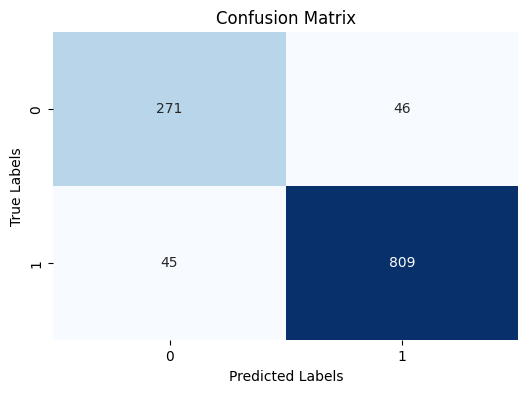

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(list_true_labels, test_pred_05)

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Menangani Imbalance Data

Berikut adalah beberapa referensi jika anda ingin menangani imbalance data:
- [menggunakan pengaturan loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryFocalCrossentropy)
- [class_weight](https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99)
- [Menggunakan threshold](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)
- [Step-By-Step Framework for Imbalanced Classification Projects](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)

# Transfer Learning - Xception

In [ ]:
pretrained_model= Xception(include_top=False,
                           input_shape=(150, 150, 3),
                           pooling='avg')

pretrained_model.trainable=False

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model_xception= Sequential()
model_xception.add(pretrained_model)
model_xception.add(tf.keras.layers.Flatten())
model_xception.add(Dense(128, activation='relu'))
model_xception.add(Dense(32, activation='relu'))
model_xception.add(Dense(1, activation='sigmoid'))

In [ ]:
model_xception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21127913 (80.60 MB)
Trainable params: 266433 (1.02 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [ ]:
model_xception.compile(loss = 'binary_crossentropy',
                       optimizer='Adam',
                       metrics=['accuracy'])

history_2 = model_xception.fit(train_gen, epochs=30,
                    validation_data = test_gen,
                    callbacks=callbacks)

Epoch 1/30
147/147 [==============================] - 65s 395ms/step - loss: 0.2231 - accuracy: 0.9076 - val_loss: 0.1644 - val_accuracy: 0.9334
Epoch 2/30
147/147 [==============================] - 56s 381ms/step - loss: 0.1463 - accuracy: 0.9419 - val_loss: 0.1734 - val_accuracy: 0.9325
Epoch 3/30
147/147 [==============================] - 54s 370ms/step - loss: 0.1321 - accuracy: 0.9475 - val_loss: 0.1350 - val_accuracy: 0.9471
Epoch 4/30
147/147 [==============================] - 55s 373ms/step - loss: 0.1175 - accuracy: 0.9537 - val_loss: 0.1699 - val_accuracy: 0.9325
Epoch 5/30
147/147 [==============================] - 56s 378ms/step - loss: 0.1098 - accuracy: 0.9571 - val_loss: 0.1478 - val_accuracy: 0.9402
Epoch 6/30
147/147 [==============================] - 55s 378ms/step - loss: 0.0907 - accuracy: 0.9691 - val_loss: 0.1460 - val_accuracy: 0.9471


In [ ]:
test_results= model_xception.evaluate(test_gen,verbose=0)
print(f'loss {test_results[0]:.2f}')
print(f'acc {test_results[1]:.2f}')

In [ ]:
proba_pred= model_xception.predict(test_gen, verbose=0)
test_pred_05=tf.where(proba_pred>0.58, 1, 0)
list_true_labels= test_gen.classes
len(list_true_labels)

1171

In [ ]:
print('classification report dengan threshold 0.58')
print(classification_report(list_true_labels, test_pred_05))

classification report dengan threshold 0.55
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       317
           1       0.97      0.96      0.96       854

    accuracy                           0.95      1171
   macro avg       0.93      0.94      0.93      1171
weighted avg       0.95      0.95      0.95      1171



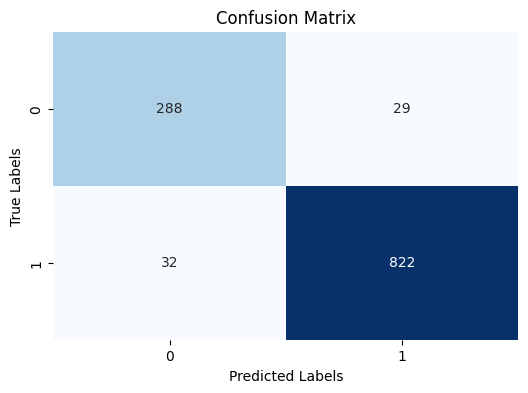

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(list_true_labels, test_pred_05)

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Transfer Learning - VGG16

In [ ]:
pretrained_model= VGG16(include_top=False,
                           input_shape=(150, 150, 3),
                           pooling='avg')

pretrained_model.trainable=False

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
model_irfan= Sequential()
model_irfan.add(pretrained_model)
model_irfan.add(tf.keras.layers.Flatten())
model_irfan.add(Dense(128, activation='relu'))
model_irfan.add(Dense(32, activation='relu'))
model_irfan.add(Dense(1, activation='sigmoid'))

In [ ]:
model_irfan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14784513 (56.40 MB)
Trainable params: 69825 (272.75 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
loss = tf.keras.losses.BinaryFocalCrossentropy(
     apply_class_balancing=True, gamma=3, from_logits=False)

model_irfan.compile(loss = loss,
                       optimizer='Adam',
                       metrics=['accuracy'])

history_3 = model_irfan.fit(train_gen, epochs=30,
                    validation_data = test_gen,
                    callbacks=callbacks)

Epoch 1/30
147/147 [==============================] - 53s 348ms/step - loss: 0.0123 - accuracy: 0.9104 - val_loss: 0.0097 - val_accuracy: 0.9146
Epoch 2/30
147/147 [==============================] - 63s 427ms/step - loss: 0.0094 - accuracy: 0.9234 - val_loss: 0.0098 - val_accuracy: 0.9445
Epoch 3/30
147/147 [==============================] - 61s 415ms/step - loss: 0.0090 - accuracy: 0.9315 - val_loss: 0.0250 - val_accuracy: 0.8984
Epoch 4/30
147/147 [==============================] - 51s 350ms/step - loss: 0.0092 - accuracy: 0.9304 - val_loss: 0.0092 - val_accuracy: 0.9513
Epoch 5/30
147/147 [==============================] - 51s 344ms/step - loss: 0.0084 - accuracy: 0.9332 - val_loss: 0.0090 - val_accuracy: 0.9513
Epoch 6/30
147/147 [==============================] - 51s 348ms/step - loss: 0.0082 - accuracy: 0.9358 - val_loss: 0.0079 - val_accuracy: 0.9530
Epoch 7/30
147/147 [==============================] - 52s 354ms/step - loss: 0.0076 - accuracy: 0.9445 - val_loss: 0.0078 - val_ac

In [ ]:
test_results= model_irfan.evaluate(test_gen,verbose=0)
print(f'loss {test_results[0]:.2f}')
print(f'acc {test_results[1]:.2f}')

loss 0.01
acc 0.95


In [ ]:
proba_pred= model_irfan.predict(test_gen, verbose=0)
test_pred_047=tf.where(proba_pred>0.47, 1, 0)
list_true_labels= test_gen.classes

print('classification report dengan threshold 0.47')
print(classification_report(list_true_labels, test_pred_047))

classification report dengan threshold 0.47
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       317
           1       0.97      0.97      0.97       854

    accuracy                           0.95      1171
   macro avg       0.94      0.94      0.94      1171
weighted avg       0.95      0.95      0.95      1171



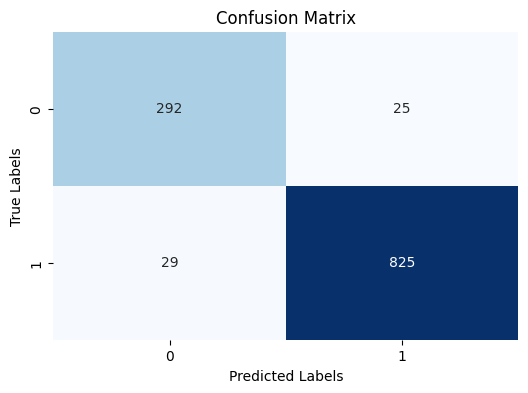

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(list_true_labels, test_pred_047)

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save Model

In [ ]:
model_irfan.save('model_irfan_best.keras')

In [ ]:
!cp /content/model_irfan_best.keras '/content/drive/MyDrive/DTS Resources'

# Streamlit

In [ ]:
!pip -q install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


Selanjutnya kita akan mencoba membuat aplikasi sederhana dari model CNN yang telah kita buat. buatlah file `app.py` menggunakan syntax berikut:

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as img

model= load_model('model_irfan_best.keras')
st.title('Model Irfan - Pneumonia Detection')

def load_and_preprocess_image(image):
    #img_inf = img.load_img(image, target_size=(224, 224))  # Sesuaikan target_size dengan ukuran yang digunakan saat pelatihan
    img_inf= image.resize((150,150))
    img_array = img.img_to_array(img_inf)
    #st.write(img_array.shape)
    img_array = img_array / 255.0  # Normalisasi nilai piksel menjadi [0, 1]
    img_array = np.expand_dims(img_array, axis=0)
    # st.write(img_array.shape)
    return img_array

def predict(image):
  preprocess_img= load_and_preprocess_image(image)
  prediction= model.predict(preprocess_img)
  return prediction


uploaded_file= st.file_uploader('Upload Image', type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
  image = img.load_img(uploaded_file)
  st.image(image, caption="Gambar yang diunggah", width=250)
  if st.button("Prediksi"):
    proba_pred= predict(image)
    prediction=tf.where(proba_pred>0.47, 1, 0) #outputnya  dua dimensi : [[1]]
    if prediction[0][0] == 1:
      st.write('Anda terditeksi Terkena Pneumonia')
    else:
      st.write('Kondisi Paru-paru anda Normal')
    # st.write(prediction)



Overwriting app.py


File `app.py` akan muncul di folder **files** google colab anda. Download file `app.py` yang ada di google colab dan anda dapat menggunakannya di lingkungan lokal pada PC atau laptop anda.

## Streamlit- Gen AI

Kita dapat mengkombinasikan Aplikasi CNN untuk deteksi Pneumonia dengan Gen AI. Berikut adalah contoh codenya.

In [ ]:
%%writefile elite_global.py
import streamlit as st
import google.generativeai as genai

api_key='gunakan api key kalian'
genai.configure(api_key=api_key)

st.title('Chatbot Elite Global')

generation_config={
    "max_output_tokens": 1000,
    "temperature": 0.8,
    "top_p": 1
}
model= genai.GenerativeModel('gemini-pro')
prompt= st.text_input("Masukan Perintah Anda:")
if st.button('Generate Text'):
  if not prompt:
    st.warning('Tolong masukan inputan perintah anda')
  else:
    with st.spinner('Elite Global sedang Menghasilkan Text Yang Anda Minta...'):
      response= model.generate_content(
        prompt,
        generation_config= generation_config,
        stream=False
      )
      st.write(response.text)


Writing elite_global.py


# Kombinasi CNN dengan Gen AI

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as img

import google.generativeai as genai


api_key='gunakan api key kalian'
genai.configure(api_key=api_key)

st.title('Chatbot Keren Elite Global')

generation_config={
    "max_output_tokens": 1000,
    "temperature": 0.8,
    "top_p": 1
}

model_genai= genai.GenerativeModel('gemini-pro')
model= load_model('model_irfan_best.keras')

def load_and_preprocess_image(image):
    #img_inf = img.load_img(image, target_size=(224, 224))  # Sesuaikan target_size dengan ukuran yang digunakan saat pelatihan
    img_inf= image.resize((150,150))
    img_array = img.img_to_array(img_inf)
    #st.write(img_array.shape)
    img_array = img_array / 255.0  # Normalisasi nilai piksel menjadi [0, 1]
    img_array = np.expand_dims(img_array, axis=0)
    # st.write(img_array.shape)
    return img_array

def predict(image):
  preprocess_img= load_and_preprocess_image(image)
  prediction= model.predict(preprocess_img)
  return prediction


uploaded_file= st.file_uploader('Upload Image', type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
  image = img.load_img(uploaded_file)
  st.image(image, caption="Gambar yang diunggah", width=250)
  if st.button("Prediksi"):
    proba_pred= predict(image)
    prediction=tf.where(proba_pred>0.47, 1, 0) #outputnya  dua dimensi : [[1]]
    if prediction[0][0] == 1:
      st.write('Anda terditeksi Terkena Pneumonia')
      with st.spinner('Elite Global sedang Menghasilkan Text untuk Menganalisis Penyakit Anda...'):
          response= model_genai.generate_content(
            'Jelaskan apa itu Pneumonia dan juga gejala yang dialami oleh seseorang yang tekenal Pneumonia',
            generation_config= generation_config,
            stream=False
          )
          st.write(response.text)


    else:
      st.write('Kondisi Paru-paru anda Normal')
    # st.write(prediction)



Overwriting app.py
